In [1]:
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras import layers, regularizers, losses, optimizers, preprocessing, applications, callbacks, Input, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# CONSTANTES

In [3]:
NUM_MODEL = '2'
DATA_AUG = True
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = IMG_SIZE + (3, )

# DATASET

In [4]:
if DATA_AUG:
    dataset_dir_train = pathlib.Path('dataset/train_with_data_aug/')
else: 
    dataset_dir_train = pathlib.Path('dataset/train/')

dataset_dir_validation = pathlib.Path('dataset/validation/')
dataset_dir_test = pathlib.Path('dataset/test/')

In [5]:
train_dataset = preprocessing.image_dataset_from_directory(dataset_dir_train, 
                                                                seed=123, 
                                                                image_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                                batch_size=BATCH_SIZE)

Found 1472 files belonging to 2 classes.


In [6]:
validation_dataset = preprocessing.image_dataset_from_directory(dataset_dir_validation, 
                                                                     seed=123, 
                                                                     image_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                                     batch_size=BATCH_SIZE)

Found 30 files belonging to 2 classes.


In [7]:
test_dataset = preprocessing.image_dataset_from_directory(dataset_dir_test, 
                                                                     seed=123, 
                                                                     image_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                                     batch_size=BATCH_SIZE)

Found 33 files belonging to 2 classes.


In [8]:
print(train_dataset.class_names)
print(validation_dataset.class_names)
print(test_dataset.class_names)
class_names = train_dataset.class_names

['defect', 'non_defect']
['defect', 'non_defect']
['defect', 'non_defect']


## train

In [9]:
# plt.figure(figsize=(15, 20))
# for images, labels in train_dataset.take(1):
#       for i in range(20):
#         ax = plt.subplot(5, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

## validation

In [10]:
# plt.figure(figsize=(15, 20))
# for images, labels in validation_dataset.take(1):
#       for i in range(20):
#         ax = plt.subplot(5, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

# test

In [11]:
# plt.figure(figsize=(15, 20))
# for images, labels in test_dataset.take(1):
#       for i in range(20):
#         ax = plt.subplot(5, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

## Configuração da peformance do dataset

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Obter a base da MobileNet_V2

### Ajustar a entrada para entrada da mobilenet_v2

In [13]:
preprocess_input = applications.mobilenet_v2.preprocess_input

### Obter o modelo do tensorflow

In [14]:
# Create the base model from the pre-trained model MobileNet V2
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

## Fine Tuning

In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True


Number of layers in the base model:  154


In [16]:
inputs = Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1024)              64226304  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                             

# COMPILE

In [17]:
opt = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CALLBACKS

In [18]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
pathfile = 'my_best_model.h5'
mc = callbacks.ModelCheckpoint(pathfile, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# TRAIN

In [19]:
history = model.fit(train_dataset, 
                    batch_size=BATCH_SIZE, 
                    epochs=200, 
                    validation_data=validation_dataset,
                    callbacks=[es, mc],
                    verbose=2
                    )

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.48226, saving model to my_best_model.h5
23/23 - 12s - loss: 0.9386 - accuracy: 0.5876 - val_loss: 0.4823 - val_accuracy: 0.8333 - 12s/epoch - 542ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.48226 to 0.47536, saving model to my_best_model.h5
23/23 - 8s - loss: 0.5200 - accuracy: 0.7140 - val_loss: 0.4754 - val_accuracy: 0.7333 - 8s/epoch - 337ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.47536 to 0.34768, saving model to my_best_model.h5
23/23 - 8s - loss: 0.3854 - accuracy: 0.8315 - val_loss: 0.3477 - val_accuracy: 0.8333 - 8s/epoch - 328ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.34768 to 0.34091, saving model to my_best_model.h5
23/23 - 7s - loss: 0.3921 - accuracy: 0.8247 - val_loss: 0.3409 - val_accuracy: 0.8667 - 7s/epoch - 326ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.34091 to 0.16962, saving model to my_best_model.h5
23/23 - 7s - loss: 0.2800 - accuracy: 0.8770 - val_loss: 0.1696 - va

Epoch 46: early stopping


# Load best model

In [20]:
model_best = load_model('my_best_model.h5')  # Load the best model

# Save best model

In [21]:
model_best.save('model_v' + NUM_MODEL + '.h5')

In [22]:
!rm my_best_model.h5 # Windows

In [23]:
import json

history_dict = history.history
json.dump(str(history_dict), open('history_v' + NUM_MODEL + '.txt', 'w'))

# Learning curves

In [24]:
num_epocas = len(history.history['loss'])

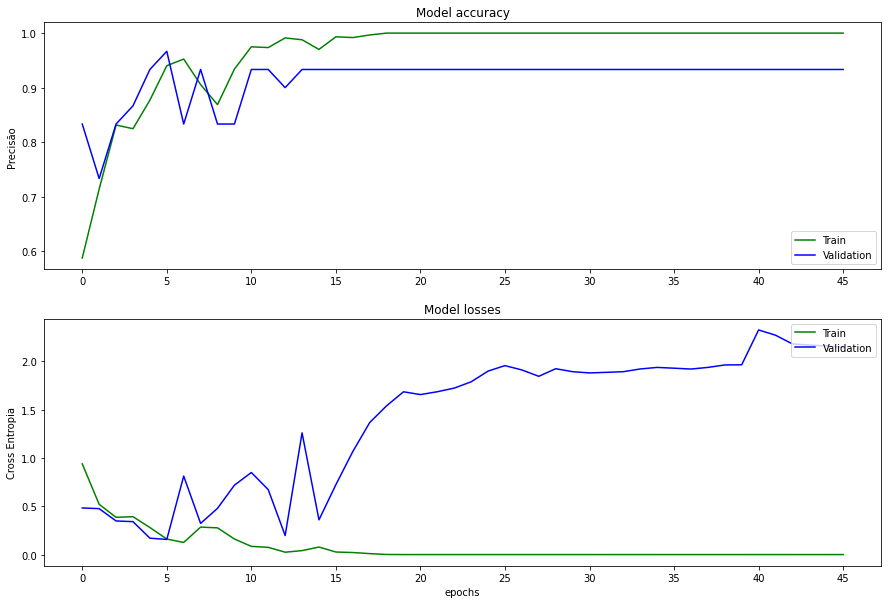

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Train')
plt.plot(val_acc, 'b', label='Validation')
plt.legend(loc='lower right')
plt.ylabel('Precisão')
plt.xticks(np.arange(0,num_epocas + 1, 5))
plt.ylim([min(plt.ylim()),1.02])
plt.title('Model accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Train')
plt.plot(val_loss, 'b', label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropia')
plt.title('Model losses')
plt.xlabel('epochs')
plt.xticks(np.arange(0,num_epocas + 1, 5))
plt.savefig(f'history_{NUM_MODEL}.png')
plt.show()

# Test

In [26]:
model_best.evaluate(test_dataset)

1/1 [==============================] - 1s 871ms/step - loss: 0.0556 - accuracy: 1.0000


[0.05562462657690048, 1.0]

# Confusion Matrix

In [27]:
for images, labels in test_dataset.take(-1):
    numpy_images = images.numpy()
    y_true = labels.numpy()
y_true

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [28]:
y_predict = np.argmax(model_best.predict(numpy_images), axis=1)
y_predict

2/2 [==============================] - 1s 209ms/step


array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1])

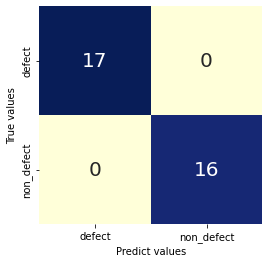

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_predict)


plt.figure(figsize=(4,4))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=False,
            cmap="YlGnBu",
            fmt='d',
            yticklabels=class_names,
            xticklabels=class_names,
            annot_kws={"size": 20})
            
plt.ylabel("True values")
plt.xlabel("Predict values")
plt.savefig(f'confusion_matrix_{NUM_MODEL}.png')
plt.show()